In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

In [3]:
# Load processed data from Week 2
with open("/content/drive/MyDrive/SmartFactory/Dataset/processed_sensor_data.json", 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

In [4]:
df.head()

,timestamp,machine_id,temperature,vibration,rpm,pressure,humidity,voltage,failure,year,...,voltage_lag_1,voltage_lag_2,temperature_roc,vibration_roc,rpm_roc,pressure_roc,humidity_roc,voltage_roc,temperature_cummax,vibration_cummax
0,2015-05-26T20:55:13.644,B-MY9,71.47,0.94,2694,7.50,65.72,215.55,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.47,0.94
1,2015-05-27T20:15:37.644,N-PR7,64.60,2.44,3054,6.96,44.25,226.71,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.60,2.44
2,2015-05-28T07:53:40.644,Y-09D,76.14,1.93,2952,6.41,51.60,243.14,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.14,1.93
3,2015-05-29T09:45:29.644,X-PYA,73.72,1.87,2607,7.13,59.94,229.21,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.72,1.87
4,2015-05-30T06:22:48.644,G-2H4,77.37,0.57,3063,4.08,47.57,221.11,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.37,0.57


In [5]:
# Prepare features and target
target = "failure"
non_features = ["timestamp", "machine_id", target]

X = df.drop(columns=non_features)
y = df[target]

In [6]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [7]:
# Define pipeline with imputation and Random Forest classifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [8]:
# Hyperparameter grid for tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt']
}

In [9]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [10]:
# Grid search with ROC AUC scoring
grid_search = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2
)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print(f"Best CV ROC AUC: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best CV ROC AUC: 0.9998


In [11]:
# Evaluate on test set
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report - Tuned Random Forest")
print(classification_report(y_test, y_pred))


Classification Report - Tuned Random Forest
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       901
           1       1.00      0.75      0.86        99

    accuracy                           0.97      1000
   macro avg       0.99      0.87      0.92      1000
weighted avg       0.98      0.97      0.97      1000



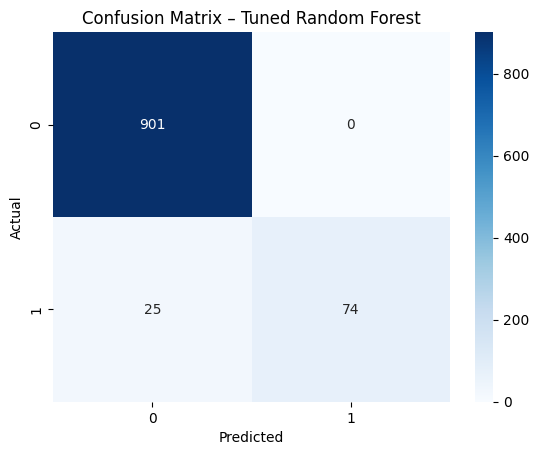

In [12]:
# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

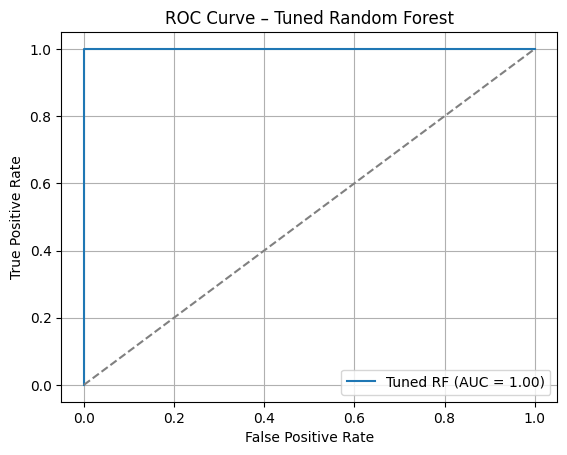

In [13]:
# ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'Tuned RF (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve – Tuned Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

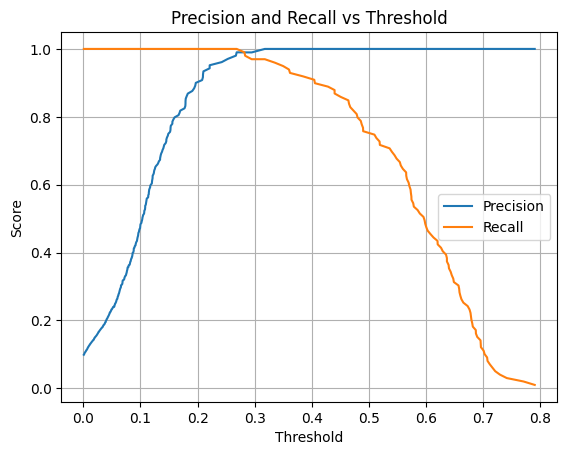

In [14]:
# Predictive Maintenance: Precision-Recall vs Threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

In [15]:
# Save best tuned model and test datasets

joblib.dump(best_model, "/content/drive/MyDrive/SmartFactory/Models/random_forest_tuned_week4.pkl")
X_test.to_json("/content/drive/MyDrive/SmartFactory/Results//Week4/X_test_week4.json", orient="records", lines=True)
pd.DataFrame({"true": y_test}).to_json("/content/drive/MyDrive/SmartFactory/Results/Week4/y_test_week4.json", orient="records", lines=True)